In [1]:
import math

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.collections as mc

from pprint import pprint

from plot import *
from building import *
from config import *
from generator import *
from dbutils import *
from scanner import *
from misc_utils import *

### Assumptions

1. Every edge for every building is divided into subparts if the length is very large. For example, a stadium's edge even though it is straight, will be divided into multiple edges to make sure the edge is detected in the scanner. This is required as the scanner's range is restricted. Doing this has no performance hit as the bottleneck is the number of features in edge, so the splitting has no performance hit on ***this*** algorithm.
2. Buildings are convex. If not, split the building into convex parts and the overlapping edges with no feature points

### Algorithm

- Tag all nodes, edges based on FOV
- Find all the buildings that are there in the given FOV
    - A building is visible if either the edge is tagged in FOV or the vertex is tagged in FOV
- For all buildings get the frontier set of edges based on the ORIGIN
- Valid edges are current all edges that are tagged in FOV as well as in the frontier.
- Remove edges from this set that are overshadowed
- Calculate the effective scope of each building
- For every building scope, remove edges that are overshadowed by this scope

In [2]:
points = generate_data(NPOINTS)
print_util(points, "points")

edges = get_edges()
print_util(edges, "edges")

edges_mat = get_adj_mat(points, edges)
print_util(edges_mat, "edges_mat")

edges_list = get_adj_list(points, edges)
print_util(edges_list, "edges_list")

points
      x     y      color
0  1.37  5.82  lightblue
1  8.67  8.21  lightblue
2  7.82  0.64  lightblue
3  2.61  1.20  lightblue
4  5.07  7.79  lightblue
5  4.60  4.83  lightblue
6  6.67  3.88  lightblue
7  8.07  2.14  lightblue
8  0.96  4.99  lightblue
9  0.29  9.14  lightblue

edges
   start  end      color
0      0    9  lightblue
1      0    8  lightblue
2      4    5  lightblue
3      4    1  lightblue
4      6    5  lightblue
5      6    1  lightblue
6      2    3  lightblue
7      2    7  lightblue

edges_mat
[[-1, -1, -1, -1, -1, -1, -1, -1, 1, 0],
 [-1, -1, -1, -1, 3, -1, 5, -1, -1, -1],
 [-1, -1, -1, 6, -1, -1, -1, 7, -1, -1],
 [-1, -1, 6, -1, -1, -1, -1, -1, -1, -1],
 [-1, 3, -1, -1, -1, 2, -1, -1, -1, -1],
 [-1, -1, -1, -1, 2, -1, 4, -1, -1, -1],
 [-1, 5, -1, -1, -1, 4, -1, -1, -1, -1],
 [-1, -1, 7, -1, -1, -1, -1, -1, -1, -1],
 [1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
 [0, -1, -1, -1, -1, -1, -1, -1, -1, -1]]

edges_list
[[[9, 0], [8, 1]],
 [[4, 3], [6, 5]],
 [[3, 6], [

In [3]:
base_angle = get_angle(DIRECTION)

viewpoint = add_vector_to_point(ORIGIN, DIRECTION, RADIUS)

viewpoint_begin = rotate_point(viewpoint, ORIGIN, FOV/2)
viewpoint_end = rotate_point(viewpoint, ORIGIN, -FOV/2)

axis_xp = rotate_point(viewpoint, ORIGIN, -90)
axis_xn = rotate_point(viewpoint, ORIGIN, 90)

print("base_angle ", base_angle)
print("viewpoint ", viewpoint)
print("viewpoint_begin ", viewpoint_begin)
print("viewpoint_end ", viewpoint_end)
print("axis_xp ", axis_xp)
print("axis_xn ", axis_xn)

base_angle  45.00000000000001
viewpoint  [4.596194077712559, 6.596194077712559]
viewpoint_begin  [1.1287131548350477, 8.401250394579352]
viewpoint_end  [6.4012503945793515, 3.1287131548350477]
axis_xp  [4.596194077712559, -2.5961940777125587]
axis_xn  [-4.596194077712559, 6.596194077712559]


In [4]:
tag_points_fov(points)
print_util(points, "points")

points
      x     y      color  normalized_angle
0  1.37  5.82      black        115.270199
1  8.67  8.21  lightblue         80.612623
2  7.82  0.64  lightblue        395.134193
3  2.61  1.20    crimson        387.958996
4  5.07  7.79  lightblue         93.793064
5  4.60  4.83      black         76.600552
6  6.67  3.88  lightblue         60.740972
7  8.07  2.14  lightblue         45.993879
8  0.96  4.99      black        117.199722
9  0.29  9.14  lightblue        132.674139



In [5]:
tag_edges_fov(points, edges)
print_util(edges)

   start  end      color
0      0    9      black
1      0    8      black
2      4    5      black
3      4    1  lightblue
4      6    5      black
5      6    1  lightblue
6      2    3  lightblue
7      2    7  lightblue



In [6]:
id_to_build_map, buildings = get_building_set(points, edges_list)
print_util(id_to_build_map, "id_to_build_map")
print_util(buildings, "buildings")

id_to_build_map
{0: 0, 1: 2, 2: 1, 3: 1, 4: 2, 5: 2, 6: 2, 7: 1, 8: 0, 9: 0}

buildings
{0: [0, 9, 8], 1: [3, 2, 7], 2: [5, 4, 6, 1]}



In [7]:
spans = get_spans(points, edges, edges_list, buildings)
print_util(spans)

[[3.14033437710063, 117.19972166716781, 8, 0.96, 4.99],
 [4.058238534142615, 115.27019948455504, 0, 1.37, 5.82],
 [7.145886928856347, 132.674138908918, 9, 0.29, 9.14]]

[[2.7298534759213724, 387.9589955204148, 3, 2.61, 1.2],
 [7.937379920351552, 395.1341930569156, 2, 7.82, 0.64],
 [8.07121428286971, 45.99387912873976, 7, 8.07, 2.14]]

[[5.400824011204216, 76.60055224876805, 5, 4.6, 4.83],
 [6.929884558923042, 60.74097178693375, 6, 6.67, 3.88],
 [7.6960379416944145, 93.79306428168863, 4, 5.07, 7.79],
 [10.664567501778963, 80.61262317697869, 1, 8.67, 8.21]]

{0: [0, 9], 1: [7, 2], 2: [6, 4]}



In [8]:
remove_overshadowing_edges(points, edges)
print_util(edges)

   start  end      color
0      0    9      black
1      0    8      black
2      4    5      black
3      4    1  lightblue
4      6    5      black
5      6    1  lightblue
6      2    3  lightblue
7      2    7  lightblue



In [9]:
remove_overshadowing_edges_spans(points, edges, spans)
print_util(edges)

   start  end      color
0      0    9  lightblue
1      0    8      black
2      4    5      black
3      4    1  lightblue
4      6    5      black
5      6    1  lightblue
6      2    3  lightblue
7      2    7  lightblue



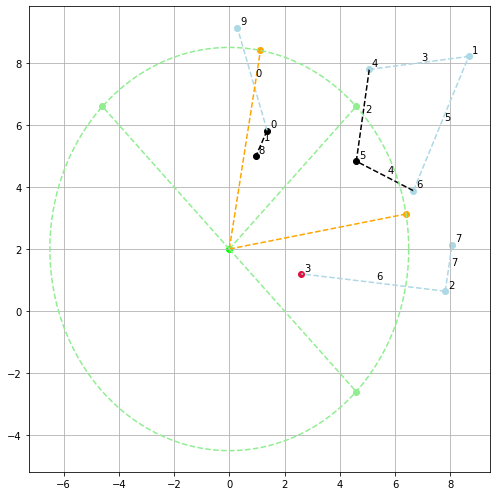

In [10]:
plot_situation(points, edges, viewpoint, viewpoint_begin, viewpoint_end, axis_xp, axis_xn)